## Import libraries

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Load data

In [83]:
hdb = pd.read_csv('./data/hdb_full.csv')
display(hdb.info())
hdb.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174397 entries, 0 to 174396
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   town              174397 non-null  object 
 1   floor_area_sqm    174397 non-null  float64
 2   flat_model        174397 non-null  object 
 3   resale_price_adj  174397 non-null  float64
 4   year              174397 non-null  int64  
 5   mth               174397 non-null  int64  
 6   f_type            174397 non-null  int64  
 7   avg_storey        174397 non-null  int64  
 8   remaining_lease   174397 non-null  int64  
 9   address           174397 non-null  object 
 10  nearest_mrt       174397 non-null  object 
 11  dist_to_mrt       174397 non-null  float64
 12  nearest_top20     174397 non-null  object 
 13  is_<2km_top20     174397 non-null  int64  
 14  time_to_city      174397 non-null  float64
 15  nearest_mall      174397 non-null  object 
 16  dist_to_mall      17

None

,town,floor_area_sqm,flat_model,resale_price_adj,year,mth,f_type,avg_storey,remaining_lease,address,nearest_mrt,dist_to_mrt,nearest_top20,is_<2km_top20,time_to_city,nearest_mall,dist_to_mall,dist_to_city
24516,WOODLANDS,101.0,Model A,349938.246192,2014,3,3,8,82,711 WOODLANDS DR 70,Woodlands,1.307928,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0,58.233333,Woodlands Mart,0.497000,18.400440
65216,SENGKANG,110.0,Improved,473066.844873,2014,4,4,14,87,321C ANCHORVALE DR,Renjong,0.432543,ROSYTH SCHOOL,0,46.633333,Compass One,0.416514,12.600938
72790,YISHUN,104.0,Model A,356125.356125,2018,6,3,8,69,407 YISHUN AVE 6,Yishun,1.518701,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0,55.516667,Junction 9,1.074755,15.695764
157566,CHOA CHU KANG,150.0,Apartment,534759.358289,2016,3,5,8,76,419 CHOA CHU KANG AVE 4,South View,0.451941,RULANG PRIMARY SCHOOL,0,51.100000,Sunshine Place,0.527867,16.342592
119527,BEDOK,82.0,New Generation,298287.827868,2019,5,2,11,57,109 BEDOK NTH RD,Bedok Reservoir,0.543417,ST. HILDA'S PRIMARY SCHOOL,1,37.283333,Bedok Point,0.850679,10.693452


## Dummy coding
Although statsmodel is able to handle categorical variables in multilinear regression models through the use of R-style formulas, we're going to dummy our categorical variables anyway because as we saw previously, there are many categories of flat model that correlate heavily with floor area, like Maisonettes and Adjoined flats.

In [90]:
# for convenience later, we want to lowercase our names as they will become our column names
# and also replace spaces with _
hdb['town'] = hdb['town'].str.lower().str.replace(' ','_')
hdb['flat_model'] = hdb['flat_model'].str.lower().str.replace(' ','_')

In [94]:
# create a new df with the dummied vars
hdb_dummy = pd.get_dummies(data=hdb, columns=['town', 'flat_model'], drop_first=True, prefix=['town', 'model'])

In [95]:
hdb_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174397 entries, 0 to 174396
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   floor_area_sqm                174397 non-null  float64
 1   resale_price_adj              174397 non-null  float64
 2   year                          174397 non-null  int64  
 3   mth                           174397 non-null  int64  
 4   f_type                        174397 non-null  int64  
 5   avg_storey                    174397 non-null  int64  
 6   remaining_lease               174397 non-null  int64  
 7   address                       174397 non-null  object 
 8   nearest_mrt                   174397 non-null  object 
 9   dist_to_mrt                   174397 non-null  float64
 10  nearest_top20                 174397 non-null  object 
 11  is_<2km_top20                 174397 non-null  int64  
 12  time_to_city                  174397 non-nul

## Multilinear Regression
We'll be performing multinear regression on our dummied dataset. The statsmodels' OLS class helps us to calculate the coefficients and p-value for each variable, and also calculates the R2 and adjusted R2 for our model, which is a measure of goodness of fit of the line of regression on the original dataset. 

In [111]:
hdb.rename(columns=({'is_<2km_top20':'is_near_top20'}), inplace=True)

In [96]:
# if we want to use patsy formula, we can't use <2km in our column name
hdb_dummy.rename(columns=({'is_<2km_top20':'is_near_top20'}), inplace=True)

In [151]:
# set our target variable resale_price_adj as y and our predictors as X
y = hdb_dummy['resale_price_adj']
X = hdb_dummy.drop(columns=(['address','nearest_mrt','nearest_mall','nearest_top20','f_type','dist_to_city','mth',
                             'resale_price_adj']))
# for sm.OLS, we need to manually add the constant
X = sm.add_constant(X, prepend=True)

In [117]:
X.columns

Index(['const', 'floor_area_sqm', 'year', 'avg_storey', 'remaining_lease',
       'dist_to_mrt', 'is_near_top20', 'time_to_city', 'dist_to_mall',
       'town_bedok', 'town_bishan', 'town_bukit_batok', 'town_bukit_merah',
       'town_bukit_panjang', 'town_bukit_timah', 'town_central_area',
       'town_choa_chu_kang', 'town_clementi', 'town_geylang', 'town_hougang',
       'town_jurong_east', 'town_jurong_west', 'town_kallang/whampoa',
       'town_marine_parade', 'town_pasir_ris', 'town_punggol',
       'town_queenstown', 'town_sembawang', 'town_sengkang', 'town_serangoon',
       'town_tampines', 'town_toa_payoh', 'town_woodlands', 'town_yishun',
       'model_adjoined_flat', 'model_apartment', 'model_dbss',
       'model_improved', 'model_improved-maisonette', 'model_maisonette',
       'model_model_a', 'model_model_a-maisonette', 'model_model_a2',
       'model_multi_generation', 'model_new_generation',
       'model_premium_apartment', 'model_premium_apartment_loft',
       'mode

### Identifying multicollinearity through the Variance Inflation Factor
One problem with running models with as many variables as we have is that multicollinearity becomes more likely. One way to check how multicollinear our variables are is to use a heatmap like before, which shows how correlated each of our variables are with each other. However, after dummying our categorical variables, we now have over 50 variables, which makes it hard to use a heatmap. So we will calculate the VIF for each variable. The higher the VIF, the more multicollinear a particular variable is with the other predictor variables.

VIF is calculated by essentially regressing each predictor variable on the other predictor variables. The less that the other predictor variables are able to explain each predictor variable, the less multicollinear that variable is with the others. One point to note is that VIF will usually be high for dummied variables, and isn't a good way to decide which dummy variables to drop.

In [118]:
y, X = dmatrices(formula_like="""np.log(resale_price_adj) ~ C(town) + C(flat_model) + floor_area_sqm + year + avg_storey + 
                         remaining_lease + dist_to_mrt + is_near_top20 + time_to_city + dist_to_mall""", 
                         data= hdb, return_type="dataframe")

In [119]:
# calculate the VIF for each predictor and store in a dictionary
vif = {X.columns[i]:variance_inflation_factor(X.values, i) for i in range(X.shape[1])}

In [120]:
# load VIFs into df to inspect by magnitude.
pd.DataFrame.from_dict(vif, orient='index').sort_values(by=0, ascending=False)

,0
Intercept,686980.927145
C(flat_model)[T.model_a],9265.981547
C(flat_model)[T.improved],8292.173557
C(flat_model)[T.new_generation],5804.887119
C(flat_model)[T.premium_apartment],3899.519961
C(flat_model)[T.simplified],2022.723553
C(flat_model)[T.apartment],1688.917879
C(flat_model)[T.standard],1381.649141
C(flat_model)[T.maisonette],1222.379618
C(flat_model)[T.model_a2],605.929936


Many of our flat models have high VIF, indicating that much of their variance can be explained by other predictor variables. However, this is to be expected. Consider a categorical variable with 3 categories, A B and C. We know that our data must belong to one of these 3 categories. If we know for one observation that it is NOT in A, it must be in B or C. With this information that A=0 for that observation, B and C become more likely. Hence for categorical variables, the categories within each variable will always be somehwat multicollinear.

### was just testing use patsy formula, and no cat vars

In [198]:
model = smf.ols(formula="""np.log(resale_price_adj) ~  floor_area_sqm  + time_to_city  + avg_storey + 
                        remaining_lease + dist_to_mrt + is_near_top20 + dist_to_mall + year""", data= hdb)
res = model.fit()
print(res.summary())

                               OLS Regression Results                               
Dep. Variable:     np.log(resale_price_adj)   R-squared:                       0.830
Model:                                  OLS   Adj. R-squared:                  0.830
Method:                       Least Squares   F-statistic:                 1.068e+05
Date:                      Thu, 17 Jun 2021   Prob (F-statistic):               0.00
Time:                              01:19:23   Log-Likelihood:             1.1657e+05
No. Observations:                    174397   AIC:                        -2.331e+05
Df Residuals:                        174388   BIC:                        -2.330e+05
Df Model:                                 8                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

### Full MLR
We are going to run MLR on the full dataset. As a reminder, these are our predictor variables:

    1) floor_area_sqm
    2) year
    3) avg_storey
    4) remaining_lease
    5) dist_to_mrt
    6) is_near_top20
    7) time_to_city
    8) dist_to_mall
    9) town (dummied)
    10) flat model (dummied)
    
First we will run without any transformations to the target or predictor vars

In [216]:
model2 = sm.OLS(y, X)
res2 = model2.fit()

In [217]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       resale_price_adj   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                 2.224e+04
Date:                Thu, 17 Jun 2021   Prob (F-statistic):               0.00
Time:                        01:26:06   Log-Likelihood:            -2.1309e+06
No. Observations:              174397   AIC:                         4.262e+06
Df Residuals:                  174344   BIC:                         4.263e+06
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -1.058e+07   9.73e+04   -108.711      0.000   -1.08e+07   -1.04e+07
floor_area_sqm                3729.0976      7.123    523.520      0.000    3715.136    3743.059
year                          5214.5871     46.536    112.054      0.000    5123.377    5305.798
avg_storey                    4078.8206     23.788    171.463      0.000    4032.196    4125.445
remaining_lease               4437.9794     16.430    270.121      0.000    4405.778    4470.181
dist_to_mrt                  -3.991e+04    420.480    -94.913      0.000   -4.07e+04   -3.91e+04
is_near_top20                 8090.1764    390.241     20.731      0.000    7325.313    8855.040
time_to_city                 -4042.1780     39.115   -103.341      0.000   -4118.843   -3965.513
dist_to_mall                 -8685.6118    378.808    -22.929      0.000   -9428.067   -7943.156
town_bedok                   -1.943e+04    764.607    -25.413      0.000   -2.09e+04   -1.79e+04
town_bishan                   6.397e+04   1067.005     59.954      0.000    6.19e+04    6.61e+04
town_bukit_batok             -3.663e+04    968.620    -37.820      0.000   -3.85e+04   -3.47e+04
town_bukit_merah              3.511e+04    983.531     35.701      0.000    3.32e+04     3.7e+04
town_bukit_panjang           -9.523e+04   1105.444    -86.150      0.000   -9.74e+04   -9.31e+04
town_bukit_timah              1.436e+05   2494.228     57.577      0.000    1.39e+05    1.48e+05
town_central_area             -635.7009   1786.869     -0.356      0.722   -4137.923    2866.521
town_choa_chu_kang           -1.032e+05   1145.698    -90.037      0.000   -1.05e+05   -1.01e+05
town_clementi                 2.706e+04    939.601     28.800      0.000    2.52e+04    2.89e+04
town_geylang                 -1.461e+04   1071.359    -13.638      0.000   -1.67e+04   -1.25e+04
town_hougang                  -5.53e+04    819.370    -67.494      0.000   -5.69e+04   -5.37e+04
town_jurong_east             -1.607e+04   1029.534    -15.606      0.000   -1.81e+04    -1.4e+04
town_jurong_west             -6.945e+04    879.553    -78.957      0.000   -7.12e+04   -6.77e+04
town_kallang/whampoa         -1.418e+04   1039.923    -13.638      0.000   -1.62e+04   -1.21e+04
town_marine_parade            1.903e+05   1653.613    115.062      0.000    1.87e+05    1.94e+05
town_pasir_ris               -3.879e+04   1045.098    -37.116      0.000   -4.08e+04   -3.67e+04
town_punggol                 -9.913e+04   1059.235    -93.584      0.000   -1.01e+05   -9.71e+04
town_queenstown               5.087e+04   1024.059     49.672      0.000    4.89e+04    5.29e+04
town_sembawang               -9.612e+04   1272.507    -75.539      0.000   -9.86e+04   -9.36e+04
town_sengkang                -1.155e+05    958.386   -120.514      0.000   -

In [219]:
preds = res2.predict(X)
resids = preds - y

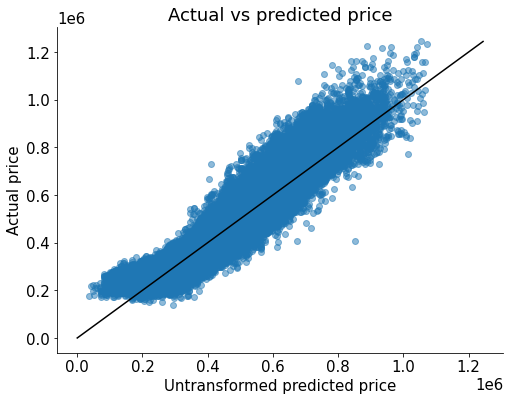

In [220]:
plt.scatter((preds), y, alpha=0.5)
plt.plot([0,np.max(y)],[0,np.max(y)], color='black')
plt.xlabel('Untransformed predicted price'), plt.ylabel('Actual price')
plt.title('Actual vs predicted price');

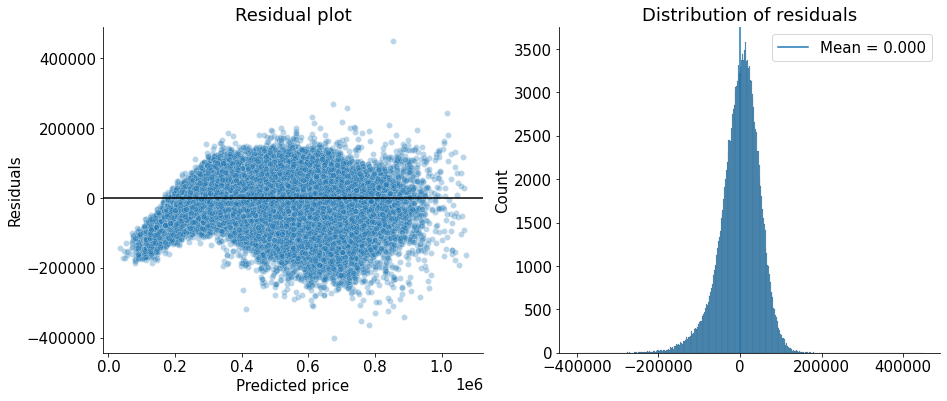

In [224]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
g = sns.scatterplot(x=(preds), y=resids, alpha=0.3, ax=ax1)
g.axhline(0, color='black')
g.set_xlabel('Predicted price'), g.set_ylabel('Residuals')
g.set_title('Residual plot')
h = sns.histplot(resids, ax=ax2)
h.axvline(resids.mean(),label='Mean = {:.3f}'.format(resids.mean()))
h.legend()
h.set_title('Distribution of residuals');

In [223]:
from sklearn.metrics import mean_squared_error
print('RMSE of model: {:3f}'.format(mean_squared_error(y, (preds), squared=False)))

RMSE of model: 49021.163658


### MLR pt 2
Some observations above:

1. There is some non-linearity present still in our predictions
2. Our residual plot displays severe heteroskedasticity. The distribution of our residuals is also slightly left skewed.

To fix this heteroskedasticity and non-linearity, we will apply a log transformation on our target variable. Log transformations are especially helpful in dealing with distributions with high outlier values.

In [244]:
y_log = np.log(y)

model3 = sm.OLS(y_log, X)
res3 = model3.fit()

In [245]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       resale_price_adj   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 2.703e+04
Date:                Thu, 17 Jun 2021   Prob (F-statistic):               0.00
Time:                        01:39:23   Log-Likelihood:             1.5400e+05
No. Observations:              174397   AIC:                        -3.079e+05
Df Residuals:                  174344   BIC:                        -3.074e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -5.6851      0.199    -28.622      0.000      -6.074      -5.296
floor_area_sqm                   0.0094   1.45e-05    645.767      0.000       0.009       0.009
year                             0.0086    9.5e-05     90.353      0.000       0.008       0.009
avg_storey                       0.0081   4.86e-05    166.159      0.000       0.008       0.008
remaining_lease                  0.0100   3.35e-05    297.568      0.000       0.010       0.010
dist_to_mrt                     -0.0839      0.001    -97.759      0.000      -0.086      -0.082
is_near_top20                    0.0210      0.001     26.368      0.000       0.019       0.023
time_to_city                    -0.0090   7.98e-05   -113.213      0.000      -0.009      -0.009
dist_to_mall                    -0.0256      0.001    -33.146      0.000      -0.027      -0.024
town_bedok                      -0.0329      0.002    -21.068      0.000      -0.036      -0.030
town_bishan                      0.1151      0.002     52.830      0.000       0.111       0.119
town_bukit_batok                -0.0805      0.002    -40.719      0.000      -0.084      -0.077
town_bukit_merah                 0.0641      0.002     31.945      0.000       0.060       0.068
town_bukit_panjang              -0.1916      0.002    -84.928      0.000      -0.196      -0.187
town_bukit_timah                 0.2570      0.005     50.478      0.000       0.247       0.267
town_central_area                0.0587      0.004     16.105      0.000       0.052       0.066
town_choa_chu_kang              -0.2164      0.002    -92.531      0.000      -0.221      -0.212
town_clementi                    0.0622      0.002     32.406      0.000       0.058       0.066
town_geylang                    -0.0340      0.002    -15.554      0.000      -0.038      -0.030
town_hougang                    -0.1110      0.002    -66.387      0.000      -0.114      -0.108
town_jurong_east                -0.0284      0.002    -13.520      0.000      -0.033      -0.024
town_jurong_west                -0.1435      0.002    -79.916      0.000      -0.147      -0.140
town_kallang/whampoa            -0.0216      0.002    -10.182      0.000      -0.026      -0.017
town_marine_parade               0.4456      0.003    132.024      0.000       0.439       0.452
town_pasir_ris                  -0.0664      0.002    -31.119      0.000      -0.071      -0.062
town_punggol                    -0.1810      0.002    -83.710      0.000      -0.185      -0.177
town_queenstown                  0.1064      0.002     50.903      0.000       0.102       0.111
town_sembawang                  -0.1829      0.003    -70.419      0.000      -0.188      -0.178
town_sengkang                   -0.2189      0.002   -111.871      0.000    

In [269]:
coefs = np.exp(res3.params)
coefs

const                          0.003
floor_area_sqm                 1.009
year                           1.009
avg_storey                     1.008
remaining_lease                1.010
dist_to_mrt                    0.920
is_near_top20                  1.021
time_to_city                   0.991
dist_to_mall                   0.975
town_bedok                     0.968
town_bishan                    1.122
town_bukit_batok               0.923
town_bukit_merah               1.066
town_bukit_panjang             0.826
town_bukit_timah               1.293
town_central_area              1.061
town_choa_chu_kang             0.805
town_clementi                  1.064
town_geylang                   0.967
town_hougang                   0.895
town_jurong_east               0.972
town_jurong_west               0.866
town_kallang/whampoa           0.979
town_marine_parade             1.561
town_pasir_ris                 0.936
town_punggol                   0.834
town_queenstown                1.112
t

Because of log transformation of the target variable, the interpretation for coefficients has changed slightly. Now, for each unit in $X_i$, y will increase by $e^{\beta_i}$ times, where ${\beta_i}$ is the regression coefficient of $X_i$.

In [249]:
preds = np.exp(res3.predict(X))
resids = preds - y

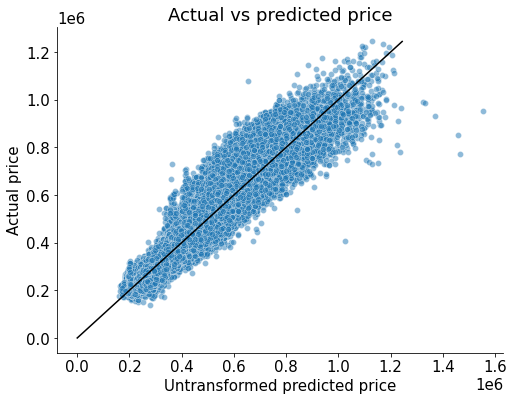

In [251]:
sns.scatterplot(x=(preds), y=y_unlog, alpha=0.5)
plt.plot([0,np.max(y_unlog)],[0,np.max(y_unlog)], color='black')
plt.xlabel('Untransformed predicted price'), plt.ylabel('Actual price')
plt.title('Actual vs predicted price');

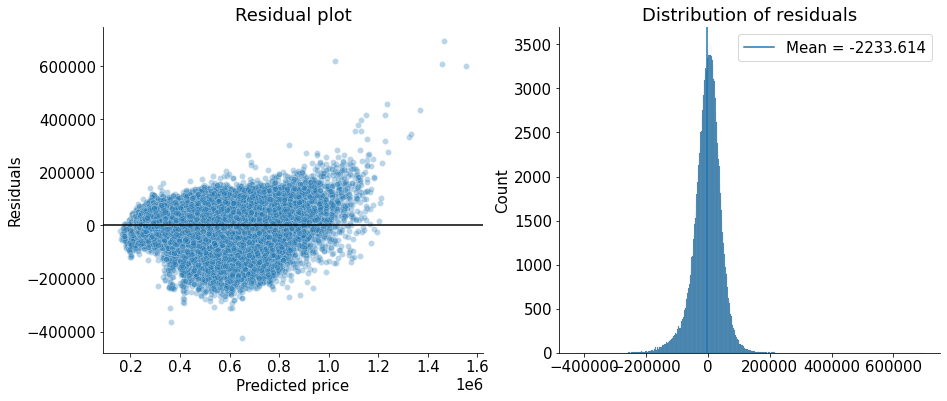

In [252]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
g = sns.scatterplot(x=(preds), y=resids, alpha=0.3, ax=ax1)
g.axhline(0, color='black')
g.set_xlabel('Predicted price'), g.set_ylabel('Residuals')
g.set_title('Residual plot')
h = sns.histplot(resids, ax=ax2)
h.axvline(resids.mean(),label='Mean = {:.3f}'.format(resids.mean()))
h.legend()
h.set_title('Distribution of residuals');

In [253]:
print('RMSE of model: {:3f}'.format(mean_squared_error(y, (preds), squared=False)))

RMSE of model: 45670.175595


Observations:

1. Our residuals are less heteroskedastic now, but we see that for prices above $1mil, we start to consistently over predict resale prices.
2. Our residuals are more normally distributed now, but their mean has shifted.
3. Our RMSE has decreased from 49k to 45k

### problems
how to fix the heteroskedasticity?? how to deal with the overprediction on the super expensive hdbs??

some next steps:
1. remove some cat vars? check p-values. idk whether this is considered proper procedure


In [259]:
temp = hdb[['town','address','floor_area_sqm','dist_to_mrt','time_to_city','is_near_top20','year','resale_price_adj']].copy()
temp['preds'] = preds
temp[temp['preds']>1200000]

,town,address,floor_area_sqm,dist_to_mrt,time_to_city,is_near_top20,year,resale_price_adj,preds
15161,kallang/whampoa,9 BOON KENG RD,119.000,0.336,22.167,0,2020,1187683.720,1204730.681
15176,kallang/whampoa,9 BOON KENG RD,119.000,0.336,22.167,0,2016,963439.893,1241161.208
15209,kallang/whampoa,7 BOON KENG RD,117.000,0.365,22.250,0,2018,1124826.385,1207821.870
30074,bishan,273B BISHAN ST 24,120.000,0.776,38.650,1,2017,1110253.853,1212261.833
30118,bishan,273B BISHAN ST 24,120.000,0.776,38.650,1,2016,978783.593,1213956.145
37290,kallang/whampoa,8 BOON KENG RD,119.000,0.352,22.950,0,2016,910802.139,1229089.583
50078,bishan,443 SIN MING AVE,199.000,1.298,43.267,1,2013,778521.411,1236468.530
100457,kallang/whampoa,59 JLN MA'MOR,181.000,1.020,37.083,1,2017,770804.587,1464752.838
100461,kallang/whampoa,59 JLN MA'MOR,180.000,1.020,37.083,1,2013,852011.110,1459193.392
113351,kallang/whampoa,55 JLN BAHAGIA,170.000,1.040,36.283,1,2020,989080.551,1324595.285
